In [1]:
import numpy as np
import pandas as pd
import time
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import urllib.request
import io
import zipfile

In [2]:
def manhattan_distance(x1, x2):
    """
    Manhattan (L1) distance: sum(|x1 - x2|)
    """
    return np.sum(np.abs(x1 - x2))

In [3]:
def knn_regress(X_train, y_train, x_test, k=3):
    """
    Performs KNN regression for a single test example (x_test).

    Parameters
    ----------
    X_train : ndarray, shape (N, d)
        Training data points (features).
    y_train : ndarray, shape (N,)
        Training target values (cnt).
    x_test : ndarray, shape (d,)
        Data point for which we want to make a prediction.
    k : int
        Number of neighbors to use.

    Returns
    -------
    prediction : float
        KNN prediction (average of neighbors).
    """
    distances = []
    for i in range(len(X_train)):
        dist = manhattan_distance(X_train[i], x_test)
        distances.append((dist, y_train[i]))
    # Sort by distance
    distances.sort(key=lambda x: x[0])
    # Get k nearest neighbors
    neighbors = distances[:k]
    # Average of neighbors -> prediction
    neighbor_values = [n[1] for n in neighbors]
    prediction = np.mean(neighbor_values)
    return prediction

In [4]:
def knn_regress_weighted(X_train, y_train, x_test, k=3, epsilon=1e-5):
    """
    Weighted KNN Regression: Closer neighbors get higher weights.
    Uses the formula w_i = 1 / (d_i + epsilon).
    """
    distances = []
    for i in range(len(X_train)):
        dist = manhattan_distance(X_train[i], x_test)
        distances.append((dist, y_train[i]))
    # Sort by distance
    distances.sort(key=lambda x: x[0])
    # Get k nearest neighbors
    neighbors = distances[:k]
    # Calculate weights
    weights = []
    values = []
    for d, val in neighbors:
        w = 1 / (d + epsilon)  # weight increases as distance decreases
        weights.append(w)
        values.append(val)
    weights = np.array(weights)
    values = np.array(values)
    # Weighted average
    prediction = np.sum(weights * values) / np.sum(weights)
    return prediction

In [5]:
def cross_validation_knn_regression(X, y, k=3, n_folds=6, weighted=False):
    """
    Applies KNN regression with 6-fold cross-validation.
    Returns average MSE, runtime, and y_test/y_pred values for all folds.
    """
    N = len(X)
    fold_size = N // n_folds
    indices = np.arange(N)
    np.random.shuffle(indices)
    mse_scores = []
    r2_scores = []
    y_test_all = []  # Actual y values from all folds
    y_pred_all = []  # Predicted y values from all folds
    fold_times = []  # Runtime for each fold

    for fold_idx in range(n_folds):
        start_time = time.time()
        test_start = fold_idx * fold_size
        test_end = test_start + fold_size
        test_indices = indices[test_start:test_end]
        train_indices = np.concatenate((indices[:test_start], indices[test_end:]))

        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_indices], y[test_indices]

        # Make predictions for test examples
        predictions = []
        for x_test in X_test:
            if weighted:
                pred = knn_regress_weighted(X_train, y_train, x_test, k=k)
            else:
                pred = knn_regress(X_train, y_train, x_test, k=k)
            predictions.append(pred)

        # Accumulate y_test and predictions for each fold
        y_test_all.extend(y_test)
        y_pred_all.extend(predictions)

        # Calculate MSE and R2
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        mse_scores.append(mse)
        r2_scores.append(r2)

        end_time = time.time()
        fold_times.append(end_time - start_time)

    # Calculate averages and totals
    avg_mse = np.mean(mse_scores)
    avg_r2 = np.mean(r2_scores)
    total_time = sum(fold_times)
    avg_time = np.mean(fold_times)

    return {
        'avg_mse': avg_mse,
        'avg_r2': avg_r2,
        'total_time': total_time,
        'avg_time': avg_time,
        'y_test_all': y_test_all,
        'y_pred_all': y_pred_all
    }

KNN Regression Analysis (K=3)
--------------------------------------------------

Non-Weighted KNN Results:
Average MSE: 0.1654
Average R2 Score: 0.8332
Total Runtime: 2.6650 seconds
Average Runtime: 0.4442 seconds

Weighted KNN Results:
Average MSE: 0.1621
Average R2 Score: 0.8375
Total Runtime: 3.5590 seconds
Average Runtime: 0.5932 seconds


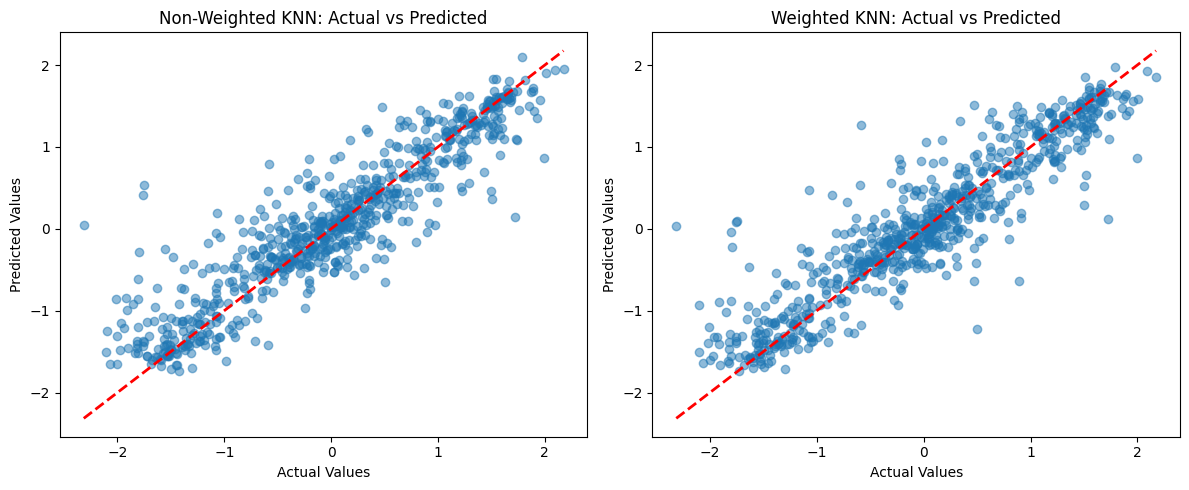

In [6]:
# Load and preprocess data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
response = urllib.request.urlopen(url)
zip_data = io.BytesIO(response.read())

# Open ZIP file and read day.csv
with zipfile.ZipFile(zip_data) as zip_file:
    with zip_file.open("day.csv") as file:
        df_bike = pd.read_csv(file)

# We can drop columns we don't want to use in the analysis
df_bike.drop(["instant", "dteday", "casual", "registered"], axis=1, inplace=True)

# Target (y): cnt
y_bike = df_bike["cnt"].values

# Input features (X): all other columns
X_bike = df_bike.drop("cnt", axis=1).values

# For standardization (normalization)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_bike)
y_scaled = scaler_y.fit_transform(y_bike.reshape(-1, 1)).flatten()

# KNN Regression Analysis (Non-Weighted and Weighted)
print("KNN Regression Analysis (K=3)")
print("-" * 50)

# Non-Weighted KNN
print("\nNon-Weighted KNN Results:")
non_weighted_results = cross_validation_knn_regression(X_scaled, y_scaled, k=3, weighted=False)
print(f"Average MSE: {non_weighted_results['avg_mse']:.4f}")
print(f"Average R2 Score: {non_weighted_results['avg_r2']:.4f}")
print(f"Total Runtime: {non_weighted_results['total_time']:.4f} seconds")
print(f"Average Runtime: {non_weighted_results['avg_time']:.4f} seconds")

# Weighted KNN
print("\nWeighted KNN Results:")
weighted_results = cross_validation_knn_regression(X_scaled, y_scaled, k=3, weighted=True)
print(f"Average MSE: {weighted_results['avg_mse']:.4f}")
print(f"Average R2 Score: {weighted_results['avg_r2']:.4f}")
print(f"Total Runtime: {weighted_results['total_time']:.4f} seconds")
print(f"Average Runtime: {weighted_results['avg_time']:.4f} seconds")

# Visualization
plt.figure(figsize=(12, 5))

# Non-Weighted KNN: Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(non_weighted_results['y_test_all'], non_weighted_results['y_pred_all'], alpha=0.5)
plt.plot([min(non_weighted_results['y_test_all']), max(non_weighted_results['y_test_all'])],
         [min(non_weighted_results['y_test_all']), max(non_weighted_results['y_test_all'])],
         'r--', lw=2)
plt.title('Non-Weighted KNN: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Weighted KNN: Actual vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(weighted_results['y_test_all'], weighted_results['y_pred_all'], alpha=0.5)
plt.plot([min(weighted_results['y_test_all']), max(weighted_results['y_test_all'])],
         [min(weighted_results['y_test_all']), max(weighted_results['y_test_all'])],
         'r--', lw=2)
plt.title('Weighted KNN: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()

#Implementation Methodology

## 1. Manhattan Distance Function Implementation

The first step in our implementation was to create the Manhattan distance function, which serves as the core distance metric for our KNN regressor. Manhattan distance calculates the absolute differences between corresponding features of two data points and sums them. Unlike Euclidean distance, Manhattan distance follows grid-like paths and is less sensitive to outliers, making it suitable for various regression problems.


## 2. Basic KNN Regression Algorithm

We implemented the core KNN regression algorithm which follows these steps:

* Calculate the Manhattan distance between the test instance and all training instances
* Sort the training instances based on their distances to the test instance
* Select the k nearest neighbors
* Average the target values of these neighbors to generate a prediction

This unweighted approach treats all neighbors equally regardless of their distance to the test instance.


## 3. Weighted KNN Regression Algorithm

To enhance the model, we implemented a weighted KNN regression variation. In this approach, closer neighbors have more influence on the prediction than distant ones. We used a weight formula of 1/(distance + epsilon), where epsilon is a small value to prevent division by zero. The final prediction is calculated as a weighted average of the target values.


## 4. Cross-Validation Implementation

To rigorously evaluate our models, we implemented a 6-fold cross-validation approach. This technique:

* Divides the dataset into 6 equal folds
* Uses each fold as a test set once while training on the remaining data
* Collects performance metrics (MSE, R²) for each fold
* Tracks runtime performance for each fold
* Aggregates and averages results across all folds

This approach provides a robust estimate of the model's performance and reduces the risk of overfitting to a particular train-test split.


## 5. Data Preprocessing

We utilized the UCI Bike Sharing Dataset for our analysis. The preprocessing steps included:

* Loading the dataset from a remote URL containing a ZIP file
* Extracting and reading the day.csv file
* Removing unnecessary columns (instant, dteday, casual, registered)
  * The reason for removing the "casual" and "registered" variables directly is that they essentially provide the result itself. When I included these variables, the model focused exclusively on them while ignoring other features. This occurred because the sum of "casual" and "registered" always equaled the model's target output ("cnt"). Eliminating these predictors forced the model to learn from the remaining features, resulting in a more robust and generalizable regression model that captures the actual patterns in the data rather than relying on this direct mathematical relationship.
* Separating features (X) and target variable (cnt)
* Applying standardization using StandardScaler to normalize both features and target


## 6. Model Evaluation

We evaluated both the non-weighted and weighted KNN regressors using the following metrics:

* Mean Squared Error (MSE): Measures the average squared difference between predicted and actual values
* R² Score: Indicates the proportion of variance in the dependent variable explained by the model
* Runtime Performance: Measures the computational efficiency of each approach

By comparing these metrics, we can determine which approach performs better in terms of prediction accuracy and computational efficiency.


# Results

The results demonstrate that the weighted KNN approach outperforms the standard non-weighted KNN regression:

## Performance Metrics:

The weighted KNN achieved a lower Mean Squared Error (MSE) of 0.1621 compared to 0.1654 for non-weighted KNN.
The weighted KNN delivered a higher R² score of 0.8375 versus 0.8332 for non-weighted KNN.
Both models show strong predictive capability with R² values above 0.83, explaining over 83% of the variance in the target variable.

## Runtime Performance:

The weighted KNN required approximately 34% more computational time (0.5932 seconds versus 0.4442 seconds per fold).
This performance difference is expected due to the additional mathematical operations required to calculate and apply weights.

## Explanation of Results
The weighted KNN approach performs better because it assigns greater importance to closer neighbors during prediction. This is particularly valuable in datasets where:

* The relationship between features and the target variable varies in different regions of the feature space.
* There are local patterns that might be diluted when all neighbors are treated equally.

The inverse distance weighting scheme (1/distance) effectively gives more influence to training examples that are more similar to the test instance, making predictions more accurate for most data points. This advantage comes at the cost of increased computational complexity, reflected in the longer runtime.

The modest improvement in performance metrics suggests that while the weighting mechanism is beneficial, the underlying data structure is well-captured even by the simpler non-weighted approach. The standardization of features prior to distance calculation likely contributed to the strong performance of both models.